In [242]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
from imgaug import augmenters as iaa

import h5py
from imgaug import augmenters as iaa

import utils
import preprocessing as pp
pp.init()

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]
trainingFolders = allTrainingFolders[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking to make sure output directories are created..
..done


# Parsing & Data Loading & Model Fitting

In [249]:
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(allTrainingFolders) 

parse = True
train = True
saveModel = True
includeAugmented = False
onlyAugmented = False

augments = [iaa.GaussianBlur(3.0)]
h5filename = 'all.h5'

if parse:
    if os.path.isfile(os.path.join(pp.h5Path, h5filename)):
        os.remove(os.path.join(pp.h5Path, h5filename))
    pp.parseImages(trainingFolders, h5filename)
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 
batch_size = 5
folderBatches = utils.chunks(allTrainingFolders, batch_size)
# print(folderBatches)

callbacks = []
epochs = 1

model = simpleConv.build_model(pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
all_x_val = []
all_y_val = []
all_x_train = []
all_y_train = []

# for batch in folderBatches:
    ##LOAD IN DATA

x_train, y_train, x_val, y_val = pp.loadH5(h5filename)

x_aug = []
y_aug = []
if includeAugmented:
    x_aug, y_aug = pp.augmentData(x_train, y_train, augments = augments)
    if onlyAugmented:
        x_train = x_aug
        y_train = y_aug
    else:
        x_train.extend(x_aug)
        y_train.extend(y_aug)


y_train = encoder.transform(y_train) #call encoder.inverse_transform() to get real class labels
y_val = encoder.transform(y_val)

#this is only needed if you are doing individual batches somehow. ignore for now. 
all_y_val.extend(y_val)
all_x_val.extend(x_val)
all_y_train.extend(y_train)
all_x_train.extend(x_train)


##FIT MODEL
if train:
# print("Fitting model on folder batch: {0}".format(batch))
    results = model.fit(np.array(x_train), np.array(y_train), 
                        validation_data = (np.array(x_val), np.array(y_val)),
                        epochs=epochs, verbose=1, callbacks = callbacks)
    
    if saveModel:
        count = 1
        outputName = ""
        while True:
            k = ''
            if includeAugmented:
                k = 'with-aug'
            if onlyAugmented:
                k = 'aug-only'
            s = baseModelName.format(epochs, count, k) + ".h5" 
            if not s in os.listdir(pp.outputModelPath):         
                outputName = s         
                break     
            else:         
                count+=1 
        print(outputName)
        model.save(os.path.join(pp.outputModelPath, outputName))

        
        #     model.train_on_batch(np.array(x_train), np.array(y_train))

    
#TODO:
#1. Need to shuffle the data that we're loading in, so that each call to fit has a sample for each class. 

Parsing images for class ID: n01443537. Found 648 images. 
Writing to h5 file: output/image-h5/all.h5
Parsing images for class ID: n01491361. Found 485 images. 
Writing to h5 file: output/image-h5/all.h5
Parsing images for class ID: n01494475. Found 472 images. 
Writing to h5 file: output/image-h5/all.h5
Parsing images for class ID: n01440764. Found 454 images. 
Writing to h5 file: output/image-h5/all.h5
Parsing images for class ID: n01484850. Found 530 images. 
Writing to h5 file: output/image-h5/all.h5
Wrote 2589 images to output/image-h5/all.h5


In [171]:
val_scores = model.evaluate(np.array(all_x_val), np.array(all_y_val))
train_scores = model.evaluate(np.array(all_x_train), np.array(all_y_train))

2070/2070 [==============================] - 42s 20ms/step


In [172]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))

['loss', 'acc']
val: [0.9152405714483389, 0.5761078999795896]
train: [0.8406962091796064, 0.6183574880954724]


# MODEL: BUILDING + TRAINING

# EVALUATION

In [246]:
predictions = model.predict(np.array(x_val))

In [247]:

#PRINT PREDICTION CLASSES
print(pp.topClasses(predictions[504], encoder.classes_))

#LOAD PREDICTIONS INTO DATAFRAME, compute accuracy
def predictionsToDataframe(predictions, truth, encoder):
    one = []
    two = []
    three = []
    for p in predictions:
        top = pp.topClasses(p, encoder.classes_)
        one.append(top[0][0])
        two.append(top[1][0])
        three.append(top[2][0])
        
    df = pd.DataFrame({'truth': [pp.translateID(x) for x in encoder.inverse_transform(truth)],
                      'one': one,
                      'two': two,
                      'three': three}) 

    return df

df = predictionsToDataframe(predictions, y_val, encoder)

[('tiger shark, Galeocerdo cuvieri', 0.35054117), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 0.34363523), ('hammerhead, hammerhead shark', 0.26212955)]


In [248]:
acc = len(df[df.truth == df.one])/len(df)
print("Top-1 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two)])/len(df)
print("Top-2 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two) | (df.truth == df.three) ]) / len(df)
print("Top-3 accuracy: {0}".format(acc))

# df.iloc[504]

Top-1 accuracy: 0.5992292870905588
Top-2 accuracy: 0.7630057803468208
Top-3 accuracy: 0.9556840077071291


Steps
1. Parse Image Data for all folders that you want to train on
2. Load in each batch and repeat:
    3. Apply augments to batch, if any
    4. Train batch
5. Evaluate model. 

# BATCH SELECTION

In [305]:
f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
batch_size = 50

idxs = np.random.permutation(len(train_x))
batches = utils.chunks(idxs, batch_size)
batches_sorted = [np.sort(b) for b in batches]



In [315]:
x = train_x[list(batches_sorted[0])]
y = train_y[list(batches_sorted[0])]

goldfish, Carassius auratus


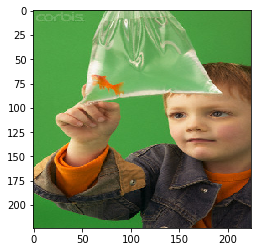

In [318]:
pp.displayImage(x[1])
print(pp.translateID(y[1].decode('utf-8')))

In [317]:
y

array([b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01484850',
       b'n01484850', b'n01484850', b'n01484850', b'n01484850',
       b'n01484850', b'n01484850'], dtype='|S9')

In [ ]:
class DataGenerator():
    
    def __init__